## Part 1: Quick intro to cudf.pandas 🚀🐼

Comment this line in or out depending on whether you want to enable `cudf.pandas`:

In [1]:
#%load_ext cudf.pandas

In [2]:
import pandas as pd
import numpy as np
import random
import string

In this section, we're running some basic pandas functions with randomly generated data and timing them.

In [3]:
STRINGS = ["".join(random.choices("abcdefg", k=5)) for _ in range(1000)] + [None]    

def make_df(size):
    return pd.DataFrame(
        {
            "id": np.random.randint(low=0, high=100, size=size),
            "x": np.random.rand(size),
            "y": np.random.rand(size),
            "s": random.choices(STRINGS, k=size)
        }
    )

df1 = make_df(10_000_000)
df2 = make_df(10_000)

In [4]:
%%time
df1.groupby("id").mean()

CPU times: user 125 ms, sys: 32.6 ms, total: 158 ms
Wall time: 155 ms


<timed eval>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.


,x,y
id,,
0,0.500602,0.499141
1,0.499032,0.500200
2,0.501185,0.499214
3,0.500134,0.500482
4,0.501114,0.500703
...,...,...
95,0.499146,0.501045
96,0.500299,0.500140
97,0.501476,0.500861


In [5]:
%%time
df1["s"].str.contains("a")

CPU times: user 2.79 s, sys: 59.4 ms, total: 2.85 s
Wall time: 2.84 s


0          False
1          False
2           True
3          False
4           True
           ...  
9999995     True
9999996     True
9999997     True
9999998     True
9999999     True
Name: s, Length: 10000000, dtype: object

In [6]:
%%time
df1.merge(df2, on=["id", "s"], how="left")

CPU times: user 2.53 s, sys: 388 ms, total: 2.91 s
Wall time: 2.91 s


,id,x_x,y_x,s,x_y,y_y
0,77,0.969692,0.971755,bbgbe,NaN,NaN
1,91,0.626281,0.314240,dfegg,0.790885,0.276398
2,64,0.120894,0.761286,ddabe,NaN,NaN
3,86,0.344029,0.731365,eegfe,NaN,NaN
4,39,0.945906,0.175984,adfbf,NaN,NaN
...,...,...,...,...,...,...
10059809,75,0.507273,0.266225,accbd,NaN,NaN
10059810,37,0.380925,0.941207,agfbe,NaN,NaN
10059811,93,0.530076,0.176642,abgaa,NaN,NaN
10059812,85,0.326534,0.085943,efbea,NaN,NaN


In [7]:
%%time
df1.count(axis=0)

CPU times: user 1.04 s, sys: 15.8 ms, total: 1.05 s
Wall time: 1.05 s


id    10000000
x     10000000
y     10000000
s      9989985
dtype: int64

In [8]:
%%time
df1.count(axis=1)

CPU times: user 1.04 s, sys: 32.6 ms, total: 1.07 s
Wall time: 1.07 s


0          4
1          4
2          4
3          4
4          4
          ..
9999995    4
9999996    4
9999997    4
9999998    4
9999999    4
Length: 10000000, dtype: int64

### How does this work?

When we did `%load_ext cudf.pandas`, we made it so that `import pandas` (or any submodules) imports a proxy module:

In [9]:
pd

<module 'pandas' from '/home/ashwin/miniconda3/envs/cudf-dev/lib/python3.10/site-packages/pandas/__init__.py'>

That proxy module is composed of proxy functions, and proxy types containing proxy methods:

In [10]:
print(type(pd.read_csv))
print(type(pd.DataFrame))
print(type(pd.DataFrame.max))

<class 'function'>
<class 'type'>
<class 'function'>


Operations on proxy functions and methods dispatch to cuDF or pandas:

<img src="how-cudf-pandas-works.png" width="700">

### Why `.count(axis=1)` is slower when `cudf.pandas` is enabled?

As you can see from the diagram above, when an operation isn't supported by cuDF, we copy data from GPU to CPU and then use pandas for that operation. This copying can add signficant overhead (especially if the data is large).

### Can we use `cudf.pandas` with other libraries?

When `cudf.pandas` enabled, you can still pass DataFrames to other libraries and expect things to work:

<Axes: xlabel='x', ylabel='y'>

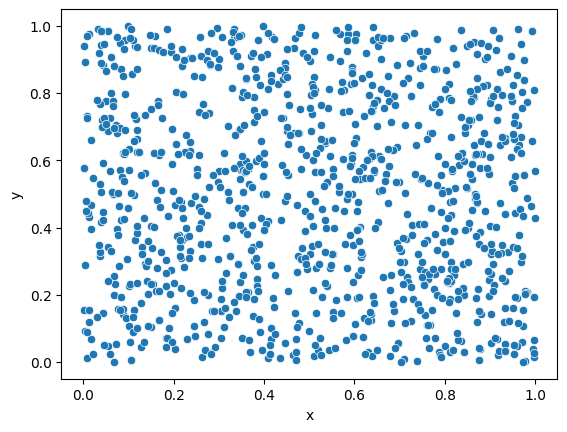

In [11]:
import seaborn as sns

sns.scatterplot(x=df2.x[::10], y=df2.y[::10])

## Part 2: Understanding Performance

Let's generate some data and do some timeseries operations with it:

In [12]:
%%time

# generate some random timeseries data:
rng = pd.date_range("2023-01-01", "2023-02-01", freq="10ms")
data = pd.DataFrame(
    {
        "a": np.random.rand(len(rng)),
        "b": np.random.rand(len(rng))
    },
    index=rng
)

# filter the data to just between 9:30am and 4pm:
data = data.iloc[rng.indexer_between_time("09:30", "16:00")]

# get daily means:
results = data.groupby(pd.Grouper(freq="1D")).mean()
results.head()

CPU times: user 8.69 s, sys: 2.17 s, total: 10.9 s
Wall time: 10.8 s


,a,b
2023-01-01,0.499671,0.500023
2023-01-02,0.499865,0.499970
2023-01-03,0.500127,0.499953
2023-01-04,0.499794,0.499936
2023-01-05,0.500282,0.500014


That runs quite slowly, even when `cudf.pandas` is enabled. Notice what happens when you run the same code with the `%%cudf.pandas.profile` magic: 

### Optimizing our code for GPU execution

The key to getting great performance with `cudf.pandas` is to minimize the number of operations that fall back to CPU. While rarely, this cannot be avoided, it often can be achieved with simple rewrites of your code. Let's rewrite the code to use operations that _are_ supported by cuDF:

In [13]:
%%time

rng = pd.date_range("2023-01-01", "2023-02-01", freq="100ms")
data = pd.DataFrame(
    {
        "a": np.random.rand(len(rng)),
        "b": np.random.rand(len(rng))
    },
    index=rng
)

# note: using datetime properties instead of `indexer_between_time`:
data = data.iloc[((rng.hour >= 9) & (rng.minute >= 30)) | (rng.hour <= 16)]

results = data.groupby(pd.Grouper(freq="1D")).mean()
results.head()

CPU times: user 6.05 s, sys: 365 ms, total: 6.42 s
Wall time: 6.24 s


,a,b
2023-01-01,0.499702,0.499558
2023-01-02,0.499623,0.499771
2023-01-03,0.500025,0.499985
2023-01-04,0.500136,0.499982
2023-01-05,0.499988,0.499545


Not only is this _much_ faster on the GPU, but it's also quite a bit faster on the CPU - a nice win-win!

## Part 3: third-party code acceleration

In this section, we'll demonstrate how `cudf.pandas` works with third-party libraries that depend on pandas.

We'll load some data into a DataFrame and use [langchain's Pandas integration](https://python.langchain.com/docs/integrations/toolkits/pandas) to answer questions about that data. We'll see that even though langchain doesn't know anything about cuDF, it will still automagically use the GPU to answer those questions much faster than with regular pandas!

⚠️ Note that at the time of writing, `langchain` is undergoing considerable changes (for example, see [here](https://github.com/langchain-ai/langchain/discussions/14243)). You may have to change some of the code in this notebook to make it work.

💰❗ Here we're using OpenAI's `gpt-4` model with langchain ([setup instructions](https://python.langchain.com/docs/integrations/llms/openai)). Note that at the time of writing, you need to buy credits from OpenAI to use this model via API.

In [14]:
from langchain.agents.agent_types import AgentType
from langchain.chat_models import ChatOpenAI
from langchain_experimental.agents.agent_toolkits import create_pandas_dataframe_agent
from langchain.llms import OpenAI

from langchain.cache import SQLiteCache
from langchain.globals import set_llm_cache
set_llm_cache(SQLiteCache(database_path=".langchain.db"))

### Loading the data

In [15]:
df = pd.concat(
    [
        pd.read_parquet("yellow_tripdata_2021-{:02d}.parquet".format(i))
        for i in range(1, 13)
    ]
)

df = df[["VendorID",
         "tpep_pickup_datetime",
         "tpep_dropoff_datetime",
         "passenger_count",
         "tip_amount"]]

df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,tip_amount
0,1,2021-01-01 00:30:10,2021-01-01 00:36:12,1.0,0.00
1,1,2021-01-01 00:51:20,2021-01-01 00:52:19,1.0,0.00
2,1,2021-01-01 00:43:30,2021-01-01 01:11:06,1.0,8.65
3,1,2021-01-01 00:15:48,2021-01-01 00:31:01,0.0,6.05
4,2,2021-01-01 00:31:49,2021-01-01 00:48:21,1.0,4.06


### Asking questions about our data

In [16]:
agent = create_pandas_dataframe_agent(
    ChatOpenAI(temperature=0, model="gpt-4"),
    df,
    agent_type=AgentType.OPENAI_FUNCTIONS,
    handle_parsing_errors=True,
)

In [17]:
%%time
print(agent.run("How many rows are there?"))

There are 30,904,308 rows in the dataframe.
CPU times: user 16.1 ms, sys: 33 µs, total: 16.1 ms
Wall time: 15.4 ms


In [18]:
%%time
print(agent.run("Which vendor received the most tips?"))

The vendor with the ID 2 received the most tips.
CPU times: user 386 ms, sys: 75.9 ms, total: 462 ms
Wall time: 461 ms


In [19]:
%%time
print(
    agent.run(
        """
        Which 30-minute, 1-hour, 2-hour, 5-hour and 24-hour windows have the most trips?
        Don't use any inplace operations please!
        """
    )
)

The 30-minute window with the most trips is from 18:30 to 19:00 on 2021-12-03.

The 1-hour window with the most trips is from 18:00 to 19:00 on 2021-12-03.

The 2-hour window with the most trips is from 18:00 to 20:00 on 2021-11-19.

The 5-hour window with the most trips is from 17:00 to 22:00 on 2021-12-03.

The 24-hour window with the most trips is from 00:00 to 23:59 on 2021-12-03.
CPU times: user 50.3 s, sys: 5.35 s, total: 55.7 s
Wall time: 55.9 s
